# Skypy meets lenstronomy
This notebooks provides examples in how to use the lenstronomy.SimulationAPI modules in conjunction with skypy in simulating (realistic) mock lenses taylored to a specific observation and instrument.

- skpypy: https://github.com/skypyproject/skypy
- lenstronomy: https://github.com/sibirrer/lenstronomy


This notebook runs with skypy version 0.5 and lenstronomy version 1.10.3.
Please make sure you appropriately credit the projects.


Authors: Simon Birrer [https://github.com/sibirrer] Vikram Bhamre [https://github.com/vikramb1] and Nicolas Tessore [https://github.com/ntessore]

Skypy documentation examples: https://skypy.readthedocs.io/en/stable/examples/index.html.

Skypy configuration example: https://skypy.readthedocs.io/en/stable/configuration_files.html.

last modified: 8.15.2022

In [2]:
# standard imports
import copy
import os
import numpy as np
import random
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline

# lenstronomy module import
import lenstronomy
from lenstronomy.SimulationAPI.sim_api import SimAPI
import lenstronomy.Plots.plot_util as plot_util
from lenstronomy.Util import constants

# skypy imports
import skypy
from skypy.pipeline import Pipeline

print(skypy.__version__)
print(lenstronomy.__version__)

0.5
1.10.3


## Define camera and observations
As an example, we define the camera and observational settings of a DES-like observation. We define one camera setting and three different observations corresponding to g,r,i band imaging.

For the complete list of possible settings, we refer to the SimulationAPI.observation_api classes. There are pre-configured settings which approximately mimic observations from current and future instruments. Be careful using those and check whether they are sufficiently accurate for your specific science case!

In [3]:
# Instrument setting from pre-defined configurations
# example notebook for using simulationAPI: https://github.com/lenstronomy/lenstronomy-tutorials/blob/main/Notebooks/Simulations/simulation_api.ipynb
from lenstronomy.SimulationAPI.ObservationConfig.DES import DES

DES_g = DES(band='g', psf_type='GAUSSIAN', coadd_years=5)
kwargs_g_band = DES_g.kwargs_single_band()
DES_r = DES(band='r', psf_type='GAUSSIAN', coadd_years=5)
kwargs_r_band = DES_r.kwargs_single_band()
DES_i = DES(band='i', psf_type='GAUSSIAN', coadd_years=5)
kwargs_i_band = DES_i.kwargs_single_band()



## Define model settings

The model settings are handled by the SimulationAPI.model_api ModelAPI class. 
The role is to return instances of the lenstronomy LightModel, LensModel, PointSource modules according to the options chosen by the user. Currently, all other model choices are equivalent to the ones provided by LightModel, LensModel, PointSource.
The current options of the class instance only describe a subset of possibilities and we refer to the specific class instances for details about all the possibilities.

For this example, we chose a single lens plane and a single source plane, elliptical Sersic profiles and an additional lensed point source.

In [4]:
kwargs_model = {'lens_model_list': ['SIE', 'SHEAR'],  # list of lens models to be used
                'lens_light_model_list': ['SERSIC_ELLIPSE'],  # list of unlensed light models to be used
                'source_light_model_list': ['SERSIC_ELLIPSE'],  # list of extended source models to be used
    }

## Generate lenstronomy SimAPI instance for the different observations
Here we make an instanbce of the SimAPI class and execute the major tasks accessible as the interface to the ImSim core module.

In [5]:
numpix = 64  # number of pixels per axis of the image to be modelled

# here we define the numerical options used in the ImSim module. 
# Have a look at the ImageNumerics class for detailed descriptions.
# If not further specified, the default settings are used.
kwargs_numerics = {'point_source_supersampling_factor': 1, 'supersampling_factor': 3}

sim_g = SimAPI(numpix=numpix, kwargs_single_band=kwargs_g_band, kwargs_model=kwargs_model)
sim_r = SimAPI(numpix=numpix, kwargs_single_band=kwargs_r_band, kwargs_model=kwargs_model)
sim_i = SimAPI(numpix=numpix, kwargs_single_band=kwargs_i_band, kwargs_model=kwargs_model)

# return the ImSim instance. With this class instance, you can compute all the
# modelling accessible of the core modules. See class documentation and other notebooks.
imSim_g = sim_g.image_model_class(kwargs_numerics)
imSim_r = sim_r.image_model_class(kwargs_numerics)
imSim_i = sim_i.image_model_class(kwargs_numerics)

## Generate galaxy population with skypy

We are using skypy to render a galaxy distribution in terms of brightness, color and size.
Skypy uses a yml file as a configuration and a pipeline with an astropy.table return format.

In [6]:

# config file relative to the path of this jupyter notebook
path = os.getcwd()
dirpath, _ = os.path.split(path)
module_path, _ = os.path.split(dirpath)
skypy_donfig = os.path.join(module_path, 'Data/SkyPy/des-like.yml')


pipeline = Pipeline.read(skypy_donfig)
# run the pipeline
pipeline.execute()
# access the results
print(pipeline.state)

{'cosmology': FlatLambdaCDM(name="Planck18", H0=67.7 km / (Mpc s), Om0=0.31, Tcmb0=2.725 K, Neff=3.05, m_nu=[0.   0.   0.06] eV, Ob0=0.049), 'mag_lim': 35, 'fsky': <Quantity 0.1 deg2>, 'z_range': array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2,
       1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2. , 2.1, 2.2, 2.3, 2.4, 2.5,
       2.6, 2.7, 2.8, 2.9, 3. , 3.1, 3.2, 3.3, 3.4, 3.5, 3.6, 3.7, 3.8,
       3.9, 4. , 4.1, 4.2, 4.3, 4.4, 4.5, 4.6, 4.7, 4.8, 4.9, 5. ]), 'M_star_blue': <Linear1D(slope=-0.9408582, intercept=-20.40492365)>, 'phi_star_blue': <Exponential1D(amplitude=0.00370253, tau=-9.73858)>, 'alpha_blue': -1.3, 'M_star_red': <Linear1D(slope=-0.70798041, intercept=-20.37196157)>, 'phi_star_red': <Exponential1D(amplitude=0.0035097, tau=-1.41649)>, 'alpha_red': -0.5, 'blue': <Table length=1106177>
        z                   M          ...       mag_z              mag_Y       
                                       ...                                      
     float6

In [7]:


def lenstronomy_config(pipeline, mag_cut=25, z_min=0.5, z_max=2, galaxy_type='bue', position_scatter=0.5):
    """
    keyword arguments of lenstronomy Sersic function selected from the skypy catalogue
    """
    source_cut = (pipeline[galaxy_type]['z'] > z_min) & (pipeline[galaxy_type]['z'] < z_max) & (pipeline[galaxy_type]['mag_g'] < mag_cut)
    pipeline_cut = pipeline[galaxy_type][source_cut]
    n = len(pipeline_cut)
    index = random.randint(0, n-1)
    source = pipeline_cut[index]

    size_arcsec = source['angular_size'] / constants.arcsec  # convert radian to arc seconds
    mag_g, mag_r, mag_i = source['mag_g'], source['mag_r'], source['mag_i']
    mag_apparent = source['M']
    e = source['ellipticity']
    phi = np.random.uniform(0, np.pi)
    e1 = e * np.cos(phi)
    e2 = e * np.sin(phi)
    if galaxy_type == 'blue':
        n_sersic = 1
    else:
        n_sersic = 4
    center_x, center_y = np.random.uniform(-position_scatter, position_scatter), np.random.uniform(-position_scatter, position_scatter)
    kwargs_galaxy_g = [{'magnitude': mag_g, 'R_sersic': size_arcsec, 'n_sersic': 1, 
                     'e1': e1, 'e2': e2, 'center_x': center_x, 'center_y': center_y}]
    kwargs_galaxy_r = [{'magnitude': mag_r, 'R_sersic': size_arcsec, 'n_sersic': 1, 
                     'e1': e1, 'e2': e2, 'center_x': center_x, 'center_y': center_y}]
    kwargs_galaxy_i = [{'magnitude': mag_i, 'R_sersic': size_arcsec, 'n_sersic': 1, 
                     'e1': e1, 'e2': e2, 'center_x': center_x, 'center_y': center_y}]
    return [kwargs_galaxy_g, kwargs_galaxy_r, kwargs_galaxy_i]



## setting lens model parameters
And finally we need a lens model. The default lensing units are in observed deflection angle (arc seconds) mapping the image to the source plane (reduced angles). In a single lens and single source plane model, this is all we need to specify and no futher cosmology is required. Skypy offers an abundance matching module to link mass and light from their catalogue (not demonstrated in this notebook).

In [8]:
kwargs_lens = [
    {'theta_E': 2.5, 'e1': 0.2, 'e2': -0.1, 'center_x': 0, 'center_y': 0},  # SIE model
    {'gamma1': 0.03, 'gamma2': 0.01, 'ra_0': 0, 'dec_0': 0}  # SHEAR model
]


## simluate image
Finally we can simulate the images with the ImageModel class instance and the lenstronomy parameters for the different bands. Note that in the specific example we included a point source (representing a quasar) in the center of the lensed galaxy. The SimulationAPI supports various options. Further down below we simulate multi-lens multi-source plane configurations too.

C:\Users\vikra\AppData\Local\Temp/ipykernel_13808/2274666695.py:40: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  f.show()


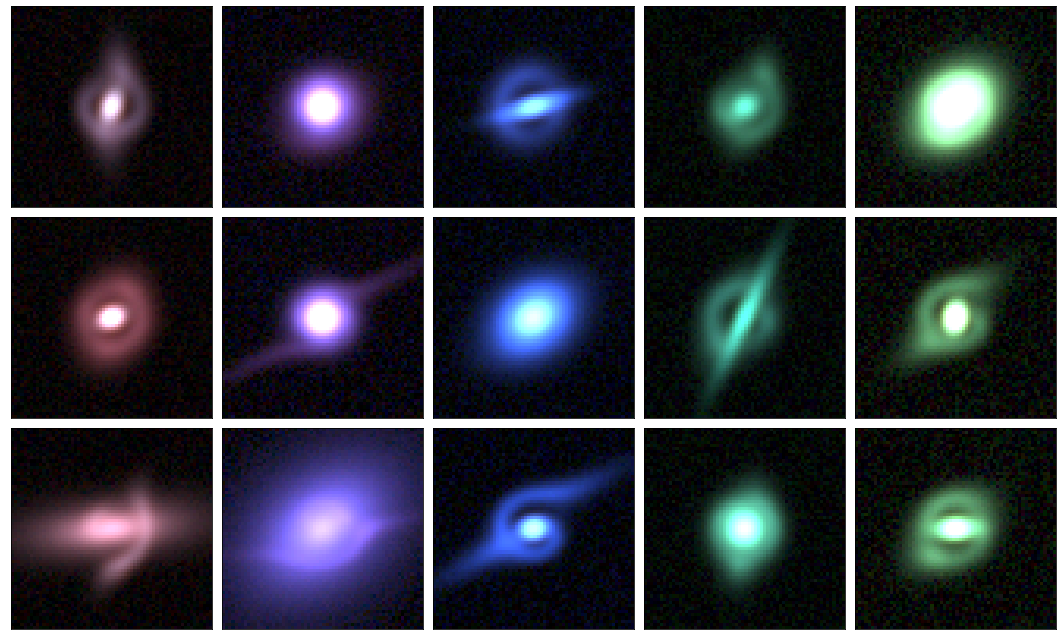

In [52]:
n_horizont, n_vertical = 5, 3
f, axes = plt.subplots(n_vertical, n_horizont, figsize=(n_horizont*3, n_vertical*3))
colours = [[10,50,50], [10,40,10], [40,40,10], [40,20,40], [10,10,30]]

for i in range(n_horizont):
    for j in range(n_vertical):
        kwargs_source = lenstronomy_config(pipeline, mag_cut=22, z_min=0.5, z_max=2, galaxy_type='blue', position_scatter=0.5)
        kwargs_lens_light = lenstronomy_config(pipeline, mag_cut=20, z_min=0.1, z_max=0.7, galaxy_type='red', position_scatter=0)

        # turn magnitude kwargs into lenstronomy kwargs
        kwargs_lens_light_g, kwargs_source_g, kwargs_ps_g = sim_g.magnitude2amplitude(kwargs_lens_light[0], kwargs_source[0])
        kwargs_lens_light_r, kwargs_source_r, kwargs_ps_r = sim_r.magnitude2amplitude(kwargs_lens_light[1], kwargs_source[1])
        kwargs_lens_light_i, kwargs_source_i, kwargs_ps_i = sim_i.magnitude2amplitude(kwargs_lens_light[2], kwargs_source[2])

        image_g = imSim_g.image(kwargs_lens, kwargs_source_g, kwargs_lens_light_g, kwargs_ps_g)
        image_r = imSim_r.image(kwargs_lens, kwargs_source_r, kwargs_lens_light_r, kwargs_ps_r)
        image_i = imSim_i.image(kwargs_lens, kwargs_source_i, kwargs_lens_light_i, kwargs_ps_i)

        # add noise
        image_g += sim_g.noise_for_model(model=image_g)
        image_r += sim_r.noise_for_model(model=image_r)
        image_i += sim_i.noise_for_model(model=image_i)

        # and plot it
        scales = colours[i]
        img = np.zeros((image_g.shape[0], image_g.shape[1], 3), dtype=float)
        img[:,:,0] = plot_util.sqrt(image_g, scale_min=0, scale_max=scales[0])
        img[:,:,1] = plot_util.sqrt(image_r, scale_min=0, scale_max=scales[1])
        img[:,:,2] = plot_util.sqrt(image_i, scale_min=0, scale_max=scales[2])
        ax = axes[j, i]
        ax.imshow(img, aspect='equal', origin='lower')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        ax.autoscale(False)

#plt.clf()
#plt.imshow(img, aspect='equal', origin='lower')
f.tight_layout()
f.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0., hspace=0.05)
f.show()